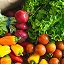

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np

n_dims = 2
filename = Path("../img/Salad_64x64.jpg")

with Image.open(filename, "r") as im:
    display(im)

In [2]:
%run ../src/kuarq.py

psi, *dims = flatten_image(filename, pad=True)
psi, mag = normalize(psi, include_magnitude=True)

dims_q = [to_qubits(x) for x in dims]

num_qubits = sum(dims_q)
num_states = 2**num_qubits

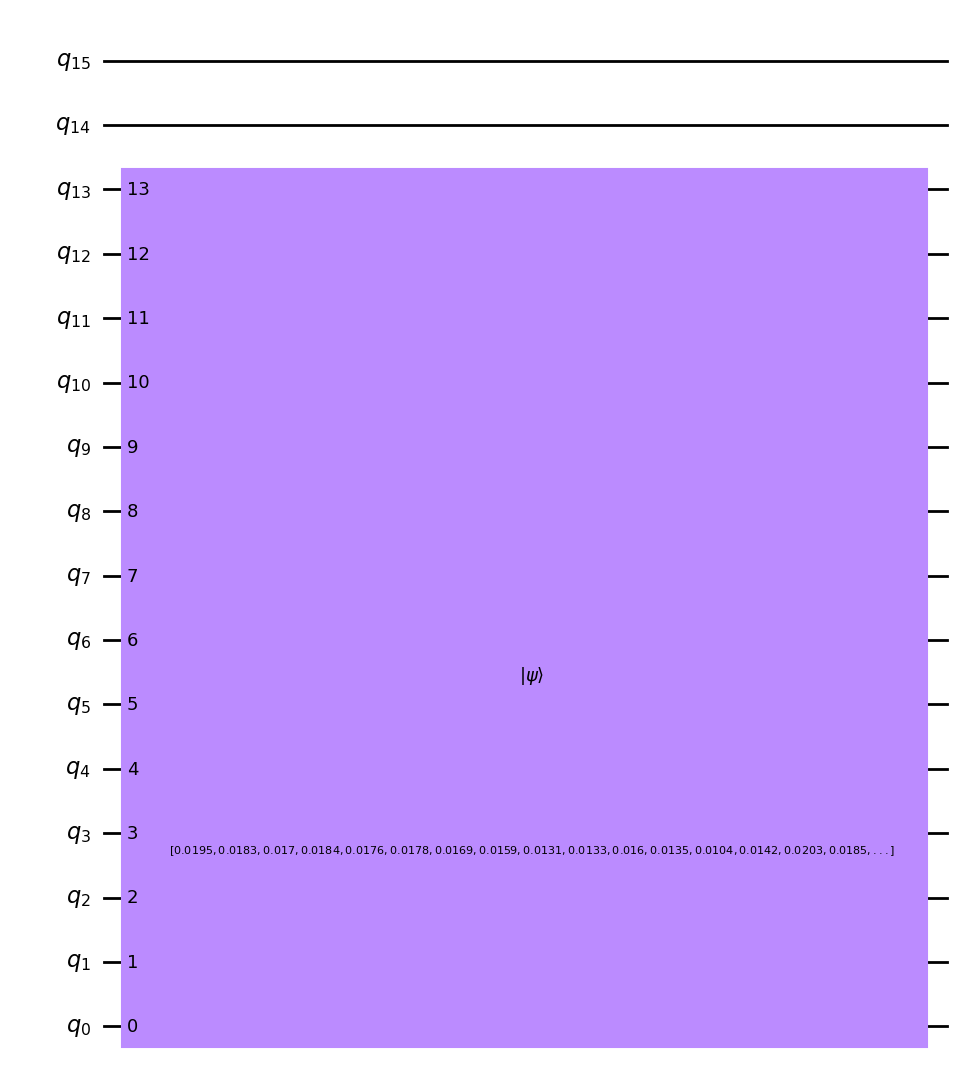

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

qc = QuantumCircuit(num_qubits + n_dims)
qc.initialize(psi, qc.qubits[:-n_dims])

qc.draw('mpl', reverse_bits=True)

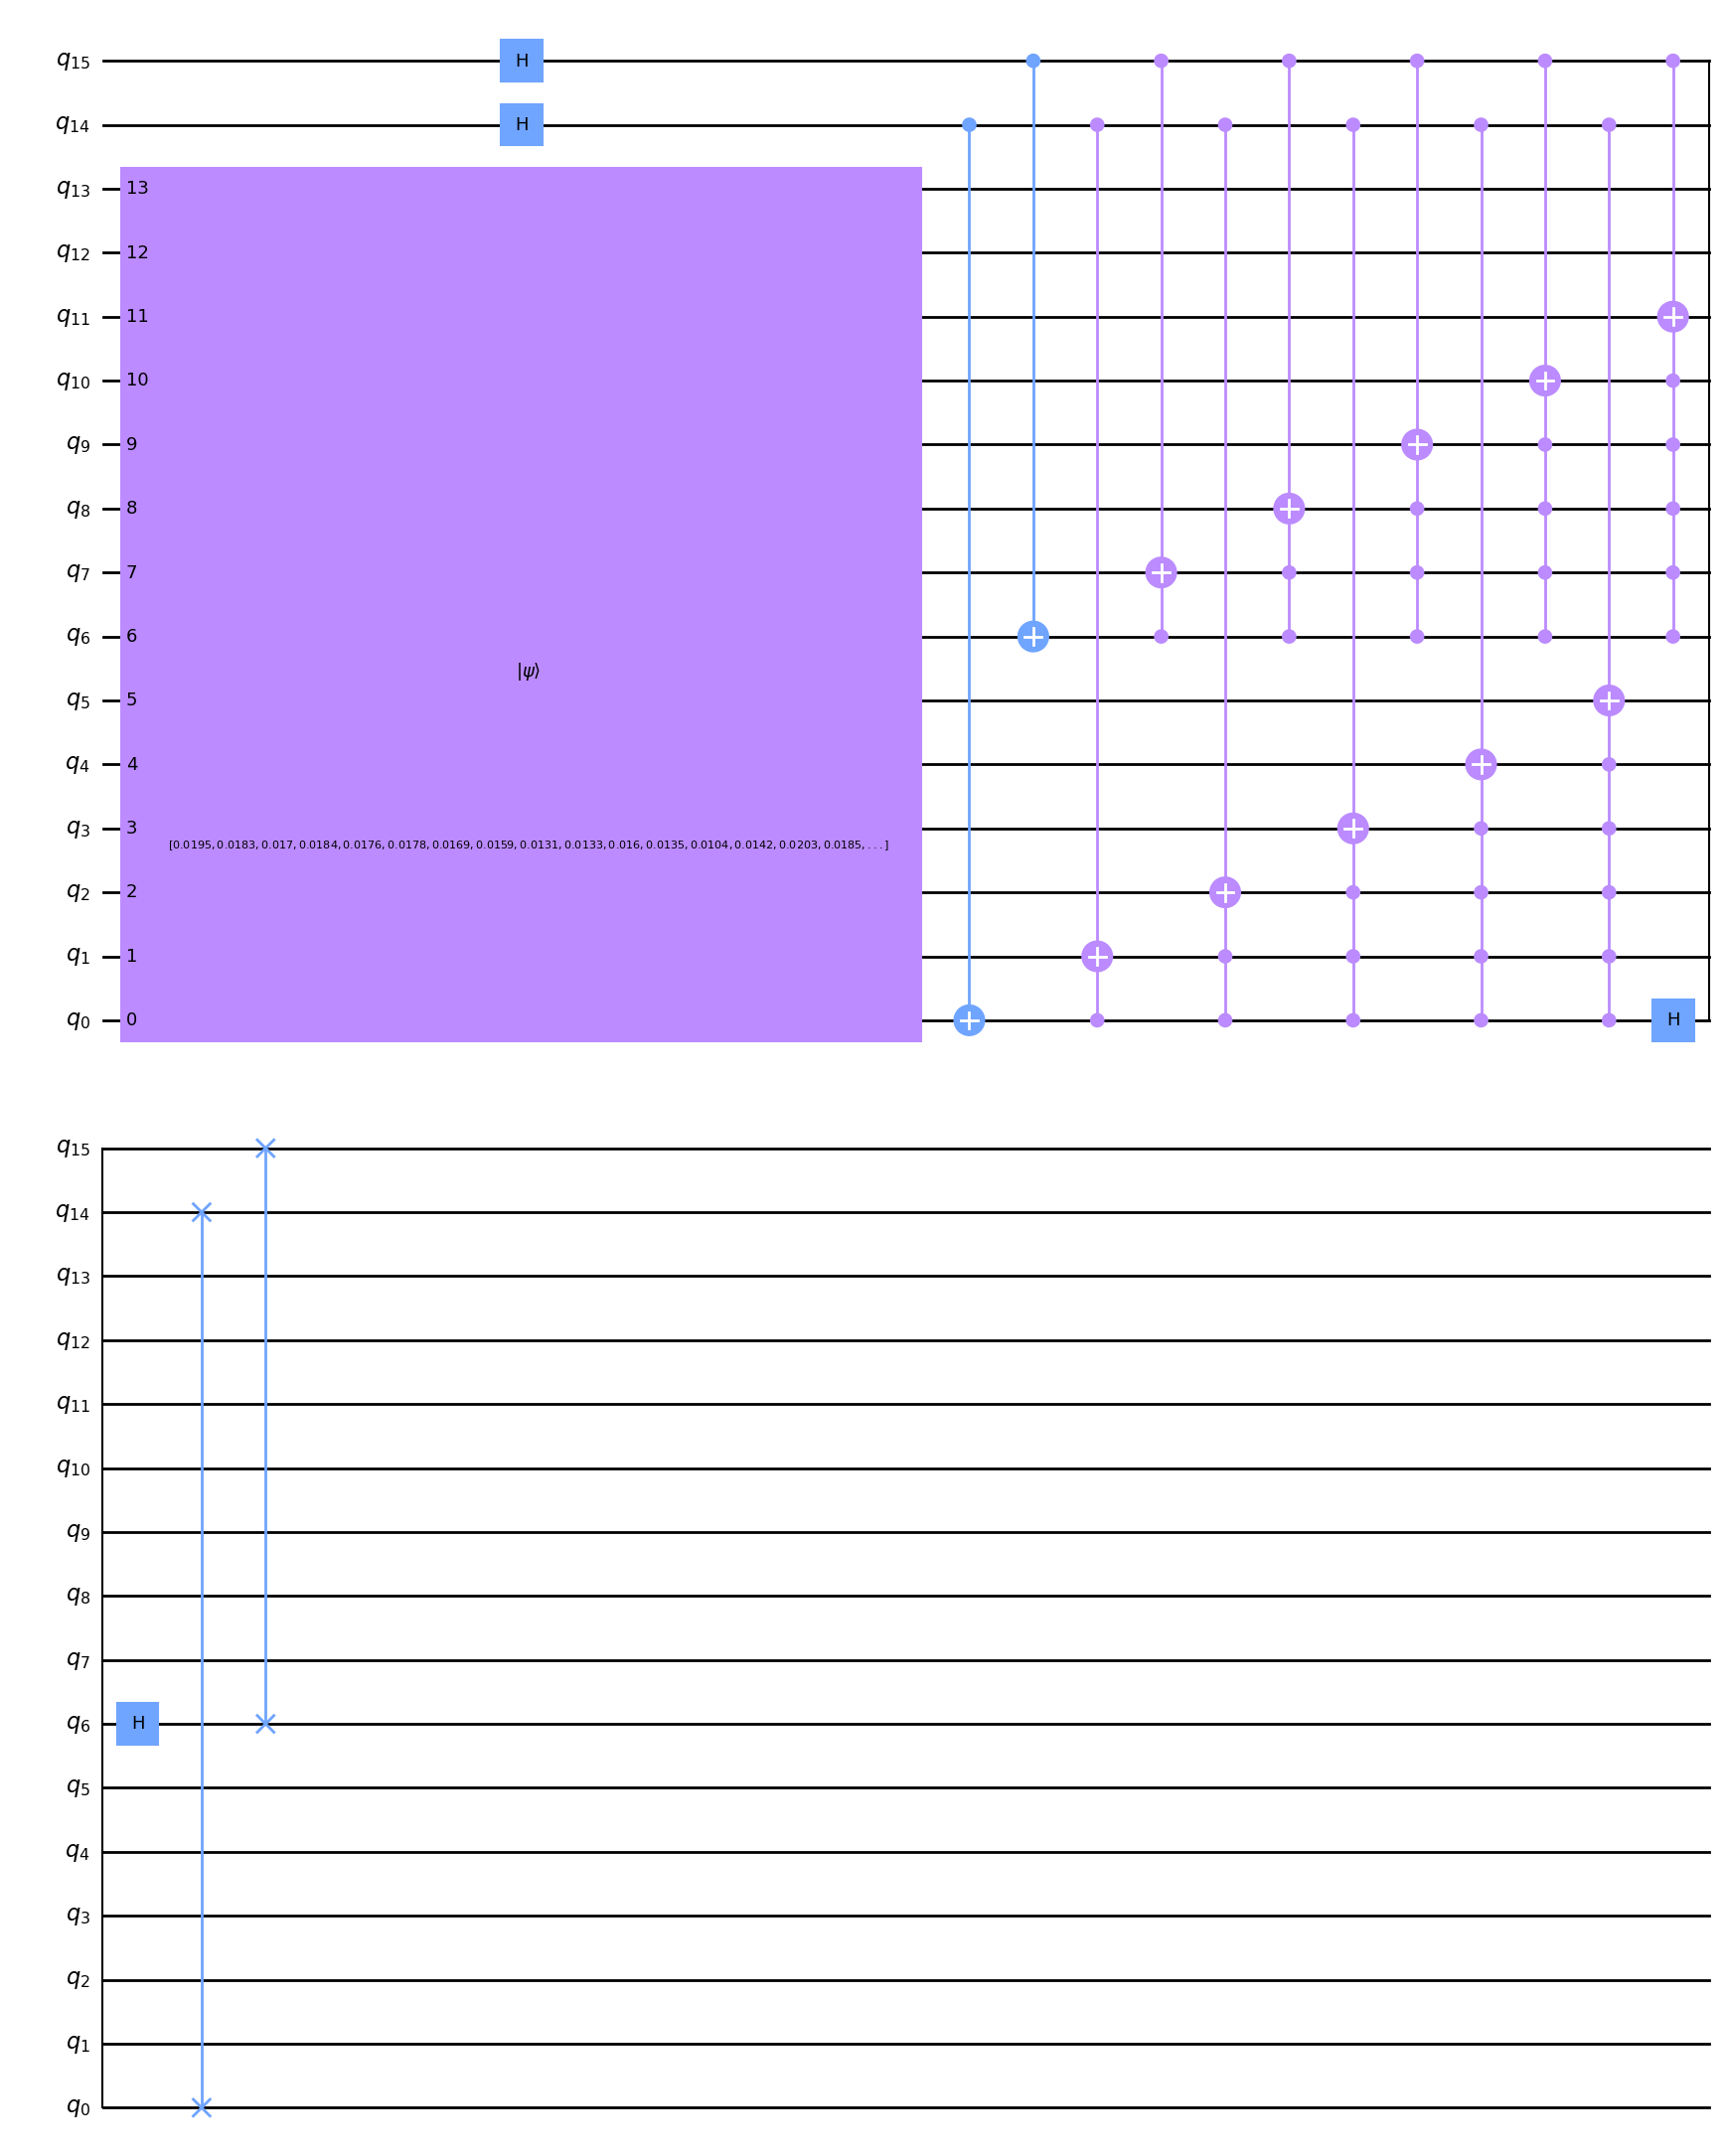

In [4]:
root = 0
for i, dim in enumerate(dims_q[:n_dims]):
    control_qubit = num_qubits+i
    qc.h(control_qubit)

    # Shift operation
    qubits = list(root + np.arange(dim))
    for i, target in enumerate(qubits):
        qc.mcx([control_qubit] + qubits[:i], target)
    
    # Apply Filter (e.g. Haar)
    qc.h(root)
    qc.swap(root, control_qubit)
    
    root += dim

qc.draw('mpl', reverse_bits=True)

In [5]:
from qiskit.quantum_info.states import Statevector

psi_out = np.real_if_close(Statevector(qc).data)

In [ ]:
img = psi_out[0*num_states:1*num_states]
img = construct_img(mag*img, dims)
img.save("output.png")